# SEGMENTACION MEDIANTE U-NET

* UNet es una red totalmente convolucional (FCN) que realiza segmentación de imágenes. Su Objetivo es predecir la clase de cada píxel (si pertenece al fondo (Background), o a una estructura especifica (Foreground)).

* UNet se basa en el FCN y se modifica de manera que produce una mejor segmentación en imágenes médicas.

## 1.1 Arquitectura

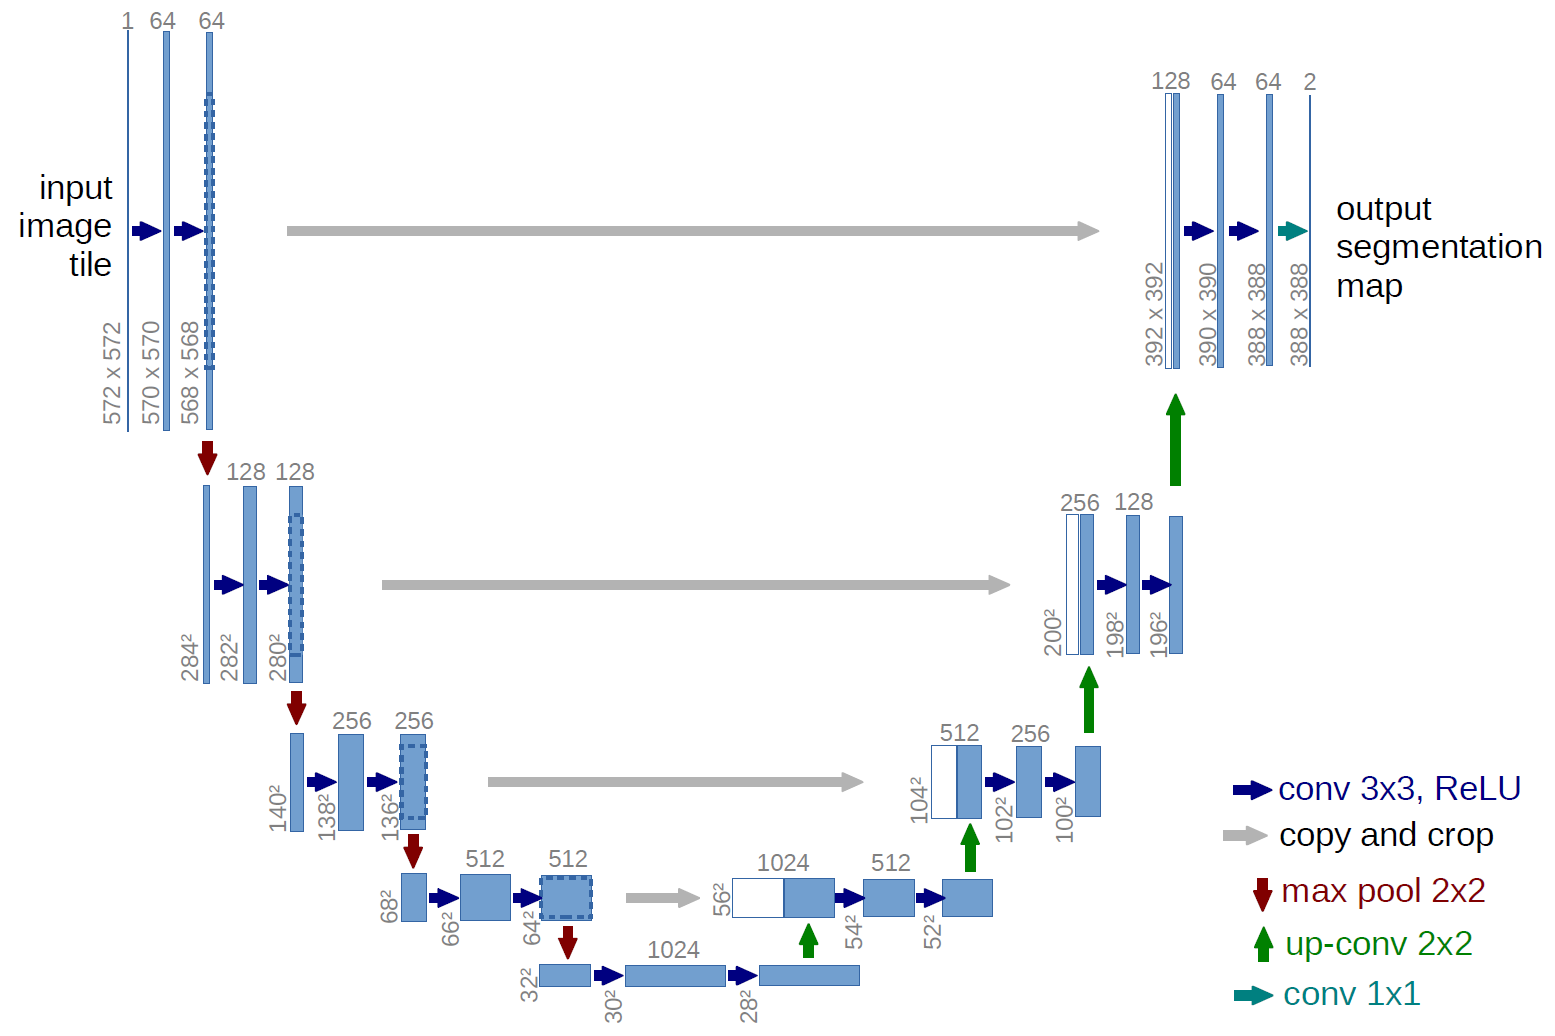



### La Arquitectura de U-Net tiene 4 partes:


    1 Contracción / disminución de muestras

    2 Cuello de Botella

    3 Expansión / aumento de muestras
    
    4 Salto de Conexion

### Contraccion/Disminucion de muestras:

* Consiste en dos convoluciones de 3x3 (convoluciones sin padding), cada una seguida de una unidad lineal rectificada (ReLU) y una operación de max Pooling de 2x2 con stride de 2 para disminuir la resolución.

* En cada paso de reducción se duplica el número de features o caracteristicas.

### Salto de conexión (copia y recorte)

* La conexión de omisión de la ruta de muestreo inferior se concatena con el mapa de características durante la ruta de muestreo superior. Estas conexiones de omisión proporcionan información local a información global durante el muestreo ascendente.

### Camino de muestreo:


* Cada paso en la ruta expansiva consiste en un up sumpling (muestreo ascendente) del mapa de características seguido de una convolución 2x2 ("convolución ascendente") esto seria una deconvolucion, una concatenación con el mapa de características correspondiente de la ruta de muestreo descendente y dos convoluciones 3x3, cada una seguida de una ReLU.


### Capa final:

* En la capa final, se utiliza una convolución 1x1 para asignar cada vector de características al número deseado de clases.


## 1.2 Ventajas

### Ventajas:

    1.  UNet combina la información de ubicación de la ruta de muestreo para finalmente obtener una información general que combina localización y contexto, lo cual es necesario para predecir un buen mapa de segmentación.

    2.  No se utiliza una capa densa, por lo que se pueden usar tamaños de imagen. 

## 1.3 Conjunto de datos y paper

 datos: https://www.kaggle.com/c/data-science-bowl-2018 
    

Paper : https://arxiv.org/abs/1505.04597

Codigo: https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

## 1.4 Codigo

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Generador de datos

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparametros

In [3]:
image_size = 128
train_path = "dataset/stage1_train/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


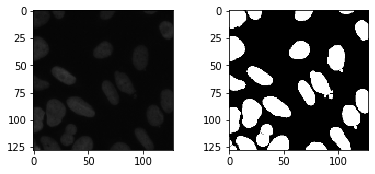

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Diferentes bloques de convolucion

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## Modelo UNET

In [7]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Entrenamiento

In [10]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)



Epoch 1/5
82/82 [==============================] - 59s 717ms/step - loss: 0.0953 - acc: 0.9465 - val_loss: 0.0980 - val_acc: 0.9406
Epoch 2/5
82/82 [==============================] - 44s 537ms/step - loss: 0.0989 - acc: 0.9449 - val_loss: 0.0411 - val_acc: 0.9689
Epoch 3/5
82/82 [==============================] - 49s 597ms/step - loss: 0.0928 - acc: 0.9468 - val_loss: 0.0406 - val_acc: 0.9685
Epoch 4/5
82/82 [==============================] - 51s 618ms/step - loss: 0.0913 - acc: 0.9477 - val_loss: 0.0401 - val_acc: 0.9688
Epoch 5/5
82/82 [==============================] - 41s 498ms/step - loss: 0.0901 - acc: 0.9483 - val_loss: 0.0401 - val_acc: 0.9697


## Evaluacion del Modelo

In [11]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

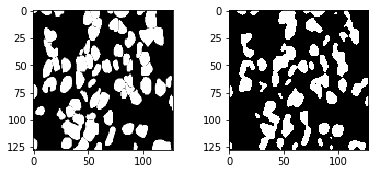

In [12]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

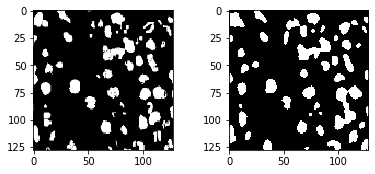

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")



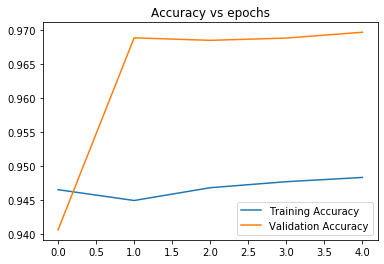

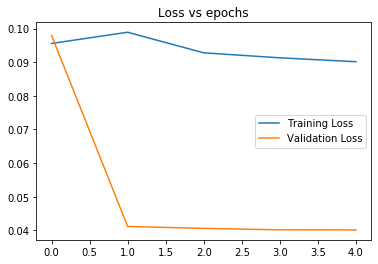

In [14]:
## visuzalimos curvas de entrenamiento

plt.figure()
plt.title("Accuracy vs epochs")
plt.plot( history.history['acc'] )
plt.plot( history.history['val_acc'] )
plt.legend(['Training Accuracy', 'Validation Accuracy'])


plt.figure()
plt.title("Loss vs epochs")
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )
plt.legend(['Training Loss', 'Validation Loss'])